In [31]:
from sklearn.metrics import mean_absolute_error
import numpy as np
import pandas as pd

data = pd.read_csv("../data/Avtice-losses.csv", skiprows=[0], names=['Timestamp', 'Active Losses'])
data['Timestamp'] = pd.to_datetime(data['Timestamp'], errors='coerce')
data.set_index('Timestamp', inplace=True)
data['Active Losses'] = pd.to_numeric(data['Active Losses'], errors='coerce')
data.dropna(inplace=True)
data.head()

# You need to convert kWh to MWh by dividing it by 1000. As all other variables use MW.
data['Active Losses'] = data['Active Losses'].astype(float)
data['Active Losses'] = data['Active Losses'] / 1000.0

#downsample from 15 min to 1 hour
data = data.loc[~data.index.duplicated(keep='first')]
data = data.resample('1H').sum()
data = data.interpolate()

/tmp/ipykernel_146835/583899417.py:6: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data['Timestamp'] = pd.to_datetime(data['Timestamp'], errors='coerce')


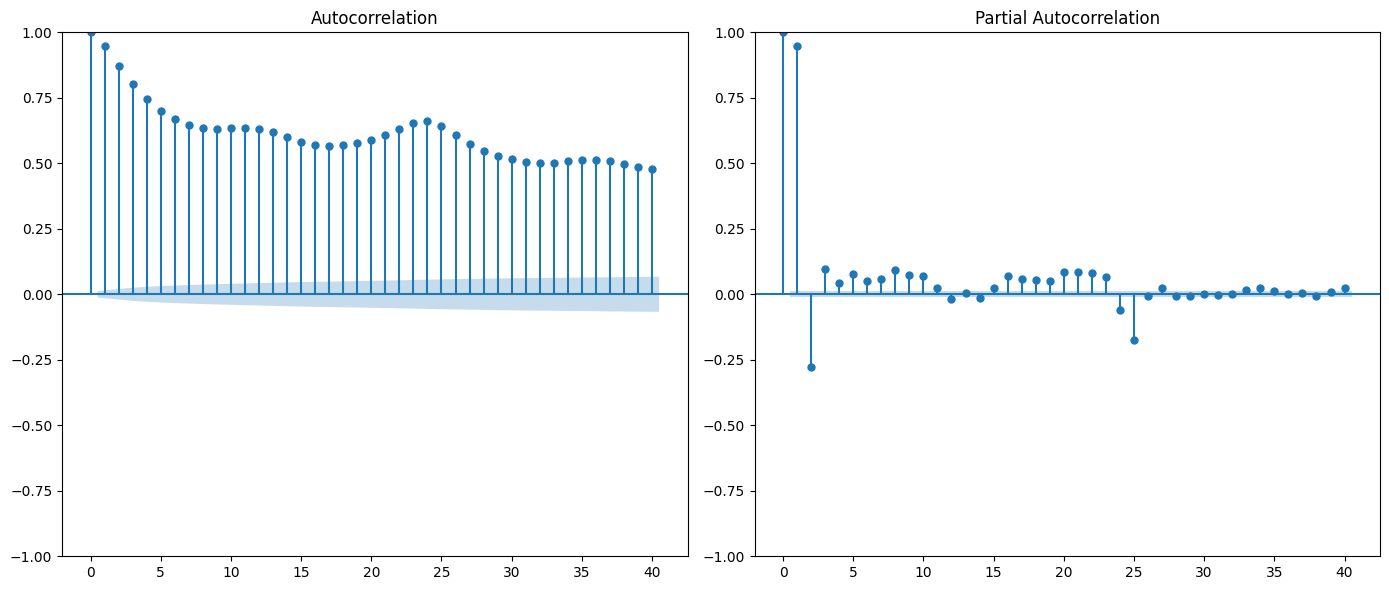

In [2]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

# Plot ACF and PACF
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
plot_acf(data['Active Losses'], lags=40, ax=axes[0])
plot_pacf(data['Active Losses'], lags=40, ax=axes[1])
plt.tight_layout()
plt.show()

In [33]:
# Decompose the time series using STL with a period of 24 for daily seasonality
model = STL(data['Active Losses'], period=24)
res = model.fit()

# Extract the seasonal, trend, and residual components
seasonal = res.seasonal
trend = res.trend
residual = res.resid

# Split the data into training and testing sets (66% training)
train_fraction = 0.66
split_idx = int(len(data) * train_fraction)
train_residual = residual.iloc[:split_idx]
test_residual = residual.iloc[split_idx:]

# Initialize and fit a linear model on the training residuals
lm = LinearRegression()
lm.fit(np.arange(len(train_residual)).reshape(-1, 1), train_residual)

# Forecast the residual component 24 hours ahead
forecast_residual_24hr = lm.predict(np.arange(len(train_residual), len(train_residual) + 24).reshape(-1, 1))

# Ensure that the seasonal and trend components are one-dimensional arrays with 24 elements
last_24hr_seasonal = seasonal.iloc[-24:].values.flatten()
last_24hr_trend = trend.iloc[-24:].values.flatten()

# Final 24-hour forecast
final_forecast_24hr = forecast_residual_24hr + last_24hr_seasonal + last_24hr_trend

# Calculate MAE for the first 24 steps in the test set
mae = mean_absolute_error(data['Active Losses'].iloc[split_idx:split_idx+24], final_forecast_24hr)

mae

43.04728807359809

In [34]:
final_forecast_24hr

array([172.93400176, 174.34869352, 175.91240453, 177.80925723,
       188.95869909, 190.03748652, 189.5080217 , 174.23563012,
       171.30334886, 162.08278624, 164.1822769 , 163.89312567,
       157.05610991, 174.27100668, 195.38169627, 195.31116085,
       186.01592856, 163.27935276, 171.63486763, 169.87295666,
       173.41053742, 181.61344477, 162.62074518,  82.57098988])